In [1]:
from pathlib import Path
import dask.array as da
import dask.dataframe as dd
import psutil
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(0,0,0,0),(0,1,0,1),(1,0,0,1)], N=128)

In [2]:
# print amount of available RAM memory
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

Available RAM: 174.42 GB


# Data location

In [3]:
lv1_path = Path('/net/pr2/projects/plgrid/plggdiamonds/lgad/2023/parquet/lv1')
lv2_path = Path('/net/pr2/projects/plgrid/plggdiamonds/lgad/2023/parquet/lv2')
lv1_path.exists(), lv2_path.exists()

(True, True)

# Pandas approach

In [4]:
single_segment_df = pd.read_parquet(lv1_path, filters=[
    ("dataset", "==", "1nA"),
    ("channel_no", "==", 0),
    ("trc_file_no", "==", 0),
    ("segment_no", "==", 0),
])
single_segment_df.head()

,segment_no,time_ns,voltage_mV,period_ns,baseline_mV,noise_sigma_mV,micropulse_no,gain_mV,phase_shift_ns,trigger_time_ns,horiz_interval_ns,dataset,channel_no,trc_file_no
0,0,0.0,-4.390240,38.081245,-2.582355,2.659545,0,0.03135,13.894989,150000.007125,0.1,1nA,0,0
1,0,0.1,-2.352476,38.081245,-2.582355,2.659545,0,0.03135,13.894989,150000.007125,0.1,1nA,0,0
2,0,0.2,-3.512442,38.081245,-2.582355,2.659545,0,0.03135,13.894989,150000.007125,0.1,1nA,0,0
3,0,0.3,-0.220716,38.081245,-2.582355,2.659545,0,0.03135,13.894989,150000.007125,0.1,1nA,0,0
4,0,0.4,-2.916813,38.081245,-2.582355,2.659545,0,0.03135,13.894989,150000.007125,0.1,1nA,0,0


In [8]:
single_segment_df.memory_usage(deep=True).sum() / (1024 ** 3)

np.float64(0.6333008958026767)

<Axes: xlabel='time_ns', ylabel='voltage_mV'>

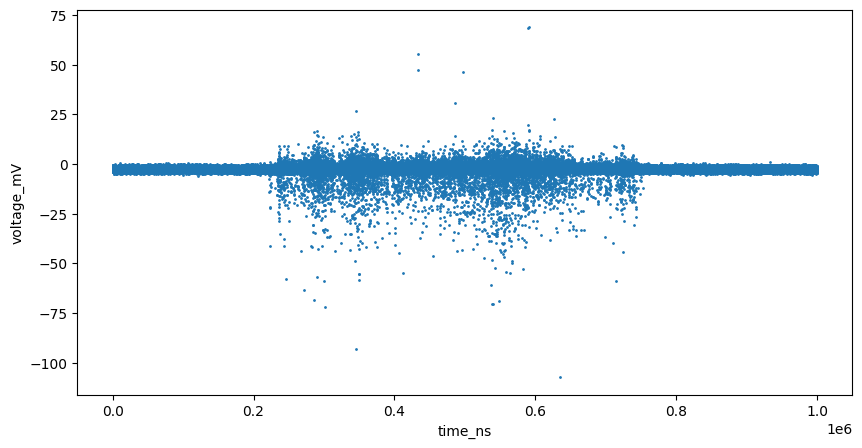

In [9]:
single_segment_df.groupby(single_segment_df.index // 40).agg({'time_ns': 'mean', 'voltage_mV': 'mean'}).plot(x='time_ns', y='voltage_mV', kind='scatter', figsize=(10, 5), s=1)

<Axes: >

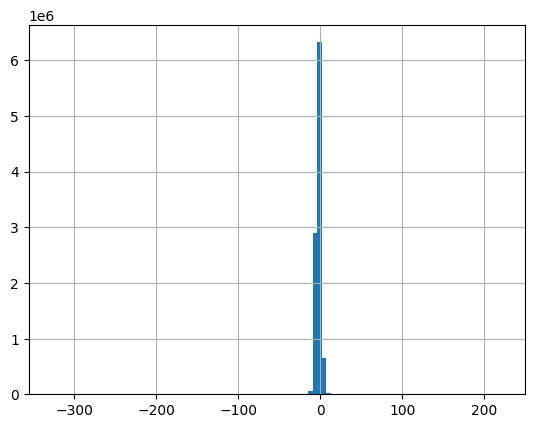

In [10]:
single_segment_df.voltage_mV.hist(bins=100)

In [11]:
df = pd.read_parquet(lv2_path, filters=[
    ("dataset", "==", "1nA"),
    ("channel_no", "==", 0),
    ("trc_file_no", "==", 0),
    ("segment_no", "==", 0),
])
df.head()

,index,trc_file_no,segment_no,delta_t_sec,peak_rise_time_ns,peak_falling_time_ns,peak_cfd_ns,peak_area_mV_ns,peak_length_ns,peak_amplitude_mV,optimum_period_ns,mean_phase_shift_ns,spread_phase_shift_ns,micropulse_no,t_mid_ns,peak_offset_ns,sign,dataset,channel_no
0,0,0,0,0.0,0.159297,0.065649,143.208996,1.725297,0.120517,8.987009,38.081245,13.894989,0.531803,3.0,128.138723,15.070273,negative,1nA,0
1,1,0,0,0.0,0.268225,0.100407,3976.002892,1.659462,0.127129,8.328661,38.081245,13.894989,0.531803,104.0,3974.344445,1.658447,negative,1nA,0
2,2,0,0,0.0,0.342113,0.063472,5225.109510,1.794267,0.125596,9.551307,38.081245,13.894989,0.531803,137.0,5231.025523,-5.916013,negative,1nA,0
3,3,0,0,0.0,0.080774,0.093265,5823.059608,1.860102,0.135631,10.585854,38.081245,13.894989,0.531803,153.0,5840.325439,-17.265832,negative,1nA,0
4,4,0,0,0.0,0.055676,0.070730,7580.744425,1.700217,0.112463,8.610810,38.081245,13.894989,0.531803,199.0,7592.062699,-11.318274,negative,1nA,0


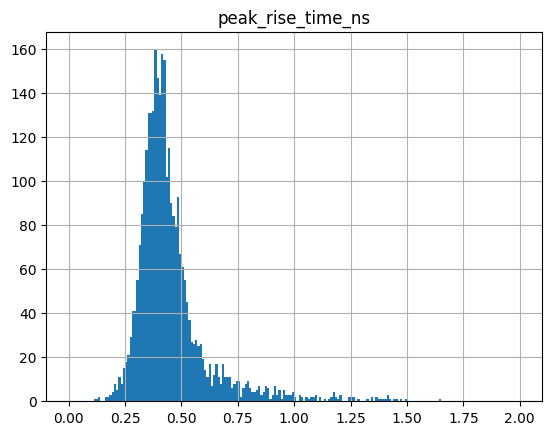

In [12]:
df.query('peak_length_ns > 1').hist('peak_rise_time_ns', bins=200, range=(0, 2));

# Dask approach

In [ ]:
from dask.distributed import Client
client = Client(interface="ib0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.22.16.77:8787/status,
Dashboard: http://172.22.16.77:8787/status,Workers: 8
Total threads: 40,Total memory: 170.00 GiB
Status: running,Using processes: True
Comm: tcp://172.22.16.77:46525,Workers: 0
Dashboard: http://172.22.16.77:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://172.22.16.77:38045,Total threads: 5
Dashboard: http://172.22.16.77:46099/status,Memory: 21.25 GiB
Nanny: tcp://172.22.16.77:39321,


2025-09-23 12:43:14,563 - distributed.nanny.memory - WARNING - Worker tcp://172.22.16.77:38045 (pid=2702696) exceeded 95% memory budget. Restarting...
2025-09-23 12:43:14,680 - distributed.scheduler - WARNING - Removing worker 'tcp://172.22.16.77:38045' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-803867b94ad72b8e8f0d9ab7194baa26', 5)} (stimulus_id='handle-worker-cleanup-1758624194.6804519')
2025-09-23 12:43:15,096 - distributed.nanny - WARNING - Restarting worker
2025-09-23 12:44:01,163 - distributed.nanny.memory - WARNING - Worker tcp://172.22.16.77:43321 (pid=2702713) exceeded 95% memory budget. Restarting...
2025-09-23 12:44:01,300 - distributed.nanny - WARNING - Restarting worker
2025-09-23 12:44:02,263 - distributed.nanny.memory - WARNING - Worker tcp://172.22.16.77:38895 (pid=2702737) exceeded 95% memory budget. Restarting...
2025-09-23 12:44:02,412 - distributed.nanny - WARNING - Restarting worker
2025-09-23 12:44:02,663 - 

In [30]:
client.close()

In [14]:
ddf = dd.read_parquet(
    lv1_path,
    filters=[
        ("dataset", "==", "64nA"),
        ("channel_no", "==", 0),
        ("trc_file_no", "==", 0),
        ("segment_no", "==", 0),
    ],
)

In [15]:
pdf = ddf[["time_ns", "voltage_mV", "trigger_time_ns"]].compute()

In [16]:
pdf.memory_usage(deep=True).sum() / (1024 ** 3)

np.float64(0.18626465648412704)

<Axes: xlabel='time_ns', ylabel='voltage_mV'>

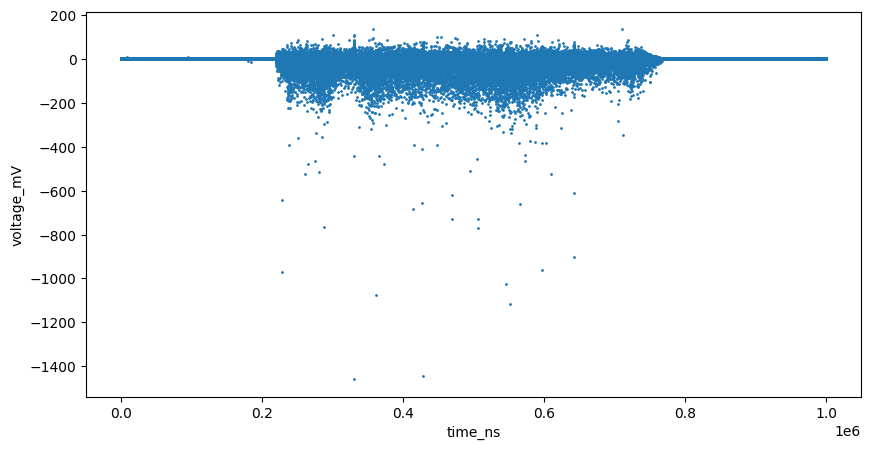

In [17]:
pdf.groupby(pdf.index // 40).agg({'time_ns': 'mean', 'voltage_mV': 'mean'}).plot(x='time_ns', y='voltage_mV', kind='scatter', figsize=(10, 5), s=1)

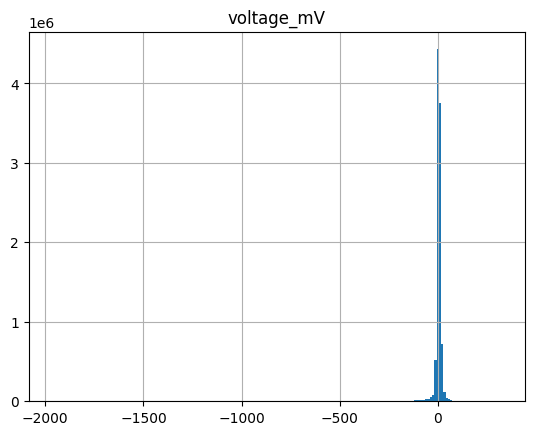

In [18]:
pdf.hist('voltage_mV', bins=200);

In [57]:
ddf = dd.read_parquet(
    lv1_path,
    filters=[
        ("dataset", "==", "64nA"),
        ("channel_no", "==", 0),
        ("trc_file_no", "<", 10),
        #("segment_no", "<", 30),
    ],
)

In [58]:
ddf.head()

,segment_no,time_ns,voltage_mV,period_ns,baseline_mV,noise_sigma_mV,micropulse_no,gain_mV,phase_shift_ns,trigger_time_ns,horiz_interval_ns,dataset,channel_no,trc_file_no
0,0,0.0,4.333675,38.081258,2.026455,5.692555,0,0.078788,36.912872,150000.021677,0.1,64nA,0,0
1,0,0.1,-9.848118,38.081258,2.026455,5.692555,0,0.078788,36.912872,150000.021677,0.1,64nA,0,0
2,0,0.2,-7.799625,38.081258,2.026455,5.692555,0,0.078788,36.912872,150000.021677,0.1,64nA,0,0
3,0,0.3,-4.332960,38.081258,2.026455,5.692555,0,0.078788,36.912872,150000.021677,0.1,64nA,0,0
4,0,0.4,-4.411757,38.081258,2.026455,5.692555,0,0.078788,36.912872,150000.021677,0.1,64nA,0,0


In [59]:
ddf.voltage_mV.mean().compute()

np.float64(1.7160761675923832)

In [60]:
ddf.voltage_mV.count().compute()

2025-09-23 12:45:31,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.05 GiB -- Worker memory limit: 21.25 GiB


np.int64(2500000250)

In [61]:
xmin = ddf.voltage_mV.min().compute()
xmax = ddf.voltage_mV.max().compute()

hist_dask, edges_dask = da.histogram(ddf.voltage_mV, bins=200, range=(xmin, xmax))

In [ ]:
hist_dask_comp = hist_dask.compute()

2025-09-23 12:46:02,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.94 GiB -- Worker memory limit: 21.25 GiB
2025-09-23 12:46:02,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.99 GiB -- Worker memory limit: 21.25 GiB
2025-09-23 12:46:02,934 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

KilledWorker: Attempted to run task ('getitem-histogram-sum-read_parquet-sum-0a89050ac2033aff4a0dfeb9cef73713', 53, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://172.22.16.77:32933. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2025-09-23 12:46:21,403 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 14.92 GiB -- Worker memory limit: 21.25 GiB
2025-09-23 12:46:21,531 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-histogram-sum-read_parquet-sum-0a89050ac2033aff4a0dfeb9cef73713', 45, 0))" coro=<Worker.execute() done, defined at /net/pr2/projects/plgrid/plggdiamonds/hpda/hpda-2025/venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-09-23 12:46:21,531 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('getitem-histogram-sum-read_parquet-sum-0a89050ac2033aff4a0dfeb9cef73713', 43, 0))" coro=<Worker.execute() done, defi

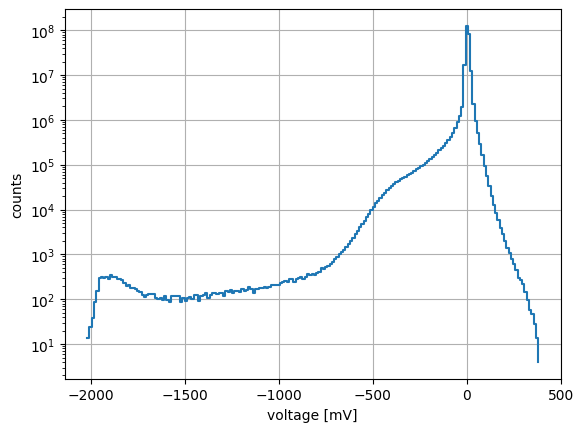

In [ ]:
plt.plot(edges_dask[:-1], hist_dask_comp, drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('voltage [mV]')
plt.ylabel('counts')
plt.grid()